<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [74]:
df = pd.read_csv('ner_dataset.csv', encoding='latin1')
df = df.fillna(method='ffill')
df.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [75]:
print('Unique words in corpus:', df['Word'].nunique())
print('Unique tags in corpus:', df['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [76]:
words = list(set(df.Word)) 
words.append('ENDPAD')
num_words = len(words)  

In [77]:
tags = list(set(df.Tag))
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [78]:
class get_sentence(object):
    def __init__(self, df):
        self.n_sentences = 1
        self.df = df

        agg_func = lambda s: [(w,p,t) for w, p, t in zip(s['Word'].values.tolist(),
                                                         s['POS'].values.tolist(),
                                                         s['Tag'].values.tolist())]
        
        self.grouped = self.df.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [79]:
getter = get_sentence(df)
sentences = getter.sentences

In [80]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [81]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [82]:
word2idx

{'petty': 1,
 'Amil': 2,
 'Lodin': 3,
 'USAID': 4,
 'Barba': 5,
 'Chileans': 6,
 'two-and-a-half': 7,
 'pence': 8,
 'Constitutional': 9,
 'interception': 10,
 'reassured': 11,
 'nursing': 12,
 'home': 13,
 'al-Sabah': 14,
 'risked': 15,
 'Ambassador': 16,
 'retirement': 17,
 'pilots': 18,
 'Daxing': 19,
 'Pro-government': 20,
 'line-of-control': 21,
 'taka': 22,
 'finest': 23,
 'inmates': 24,
 'Tangerang': 25,
 'heyday': 26,
 'music': 27,
 'TF-121': 28,
 'wings': 29,
 'perceiving': 30,
 'withdrawn': 31,
 '7-Eleven': 32,
 'Taha': 33,
 'stirred': 34,
 'pepper': 35,
 'Confessed': 36,
 'Ramdi': 37,
 'prompting': 38,
 'claim': 39,
 'commandoes': 40,
 'bi-partisan': 41,
 'clipped': 42,
 'Thursday': 43,
 'U.S.-India': 44,
 'disqualification': 45,
 'home-made': 46,
 'mill': 47,
 'U.N': 48,
 '1915': 49,
 'Regulatory': 50,
 'Iwan': 51,
 'knowingly': 52,
 'arsenal': 53,
 'Amer': 54,
 '1901': 55,
 'Nagano': 56,
 'Anguilla': 57,
 'consultation': 58,
 'levy': 59,
 'post-monsoon': 60,
 'Grosjean': 61

### Task 5: Padding Input Sentences and Creating Train/Test Splits

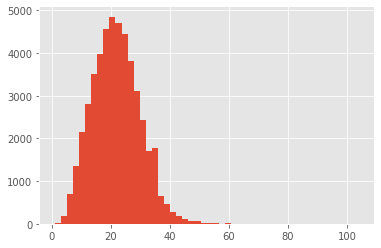

In [83]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show();

In [84]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [86]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [87]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Task 7: Train the Model

In [ ]:
!pip install livelossplot

In [90]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [91]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=1,
                               verbose=0,
                               mode='max',
                               restore_best_weights=False
                               )
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks = callbacks
)

Epoch 1/3
1080/1080 [==============================] - 335s 310ms/step - loss: 0.1939 - accuracy: 0.9557 - val_loss: 0.0694 - val_accuracy: 0.9806
Epoch 2/3
1080/1080 [==============================] - 336s 311ms/step - loss: 0.0527 - accuracy: 0.9845 - val_loss: 0.0499 - val_accuracy: 0.9849
Epoch 3/3
1080/1080 [==============================] - 330s 305ms/step - loss: 0.0377 - accuracy: 0.9885 - val_loss: 0.0463 - val_accuracy: 0.9858


### Task 8: Evaluate Named Entity Recognition Model

In [92]:
model.evaluate(X_test, np.array(y_test))

150/150 [==============================] - 3s 23ms/step - loss: 0.0477 - accuracy: 0.9854


[0.047681111842393875, 0.9854336977005005]

In [99]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:5}\t{} \n'.format('Word','True', 'Pred'))
print('-'*30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print('{:15}{:}\t{} \n'.format(words[w-1],tags[true],tags[pred]))


Word           True 	Pred 

------------------------------
General        B-per	B-per 

Hayden         I-per	I-per 

replied        O	O 

later          B-tim	B-tim 

that           I-tim	O 

month          O	O 

that           O	O 

he             O	O 

used           O	O 

only           O	O 

"              O	O 

his            O	O 

authorities    O	O 

"              O	O 

to             O	O 

adjust         O	O 

NSA            B-org	B-org 

information-collectingO	I-org 

and            O	O 

reporting      O	O 

policies       O	O 

.              O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra          O	O 

extra       